In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [2]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir):
    # 检查 name 是否在 DATA_HUB 字典中
    assert name in DATA_HUB, f'{name} does not exist in {DATA_HUB}'
    # 从 DATA_HUB 获取下载链接和哈希值
    url, sha_hash = DATA_HUB[name]
    # 创建缓存目录（如果不存在）
    os.makedirs(cache_dir, exist_ok=True)
    # 拼接本地文件路径
    fname = os.path.join(cache_dir, url.split('/')[-1])
    # 如果文件已存在
    if os.path.exists(fname):
        # 创建 SHA1 哈希对象
        sha1 = hashlib.sha1()
        # 以二进制方式读取文件内容
        with open(fname, 'rb') as f:
            while True:
                # 每次读取 1MB 数据
                data = f.read(1048576)
                if not data:
                    break
                # 更新哈希值
                sha1.update(data)
        # 如果哈希值和预期一致，直接返回文件路径
        if sha1.hexdigest() == sha_hash:
            return fname
    # 如果文件不存在或哈希值不一致，开始下载
    print(f'Downloading {fname} from {url}...')
    # 从 url 下载文件内容
    r = requests.get(url, stream=True, verify=True)
    # 以二进制写入本地文件
    with open(fname, 'wb') as f:
        f.write(r.content)
    # 返回文件路

In [4]:
def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    for name in DATA_HUB:
        download(name)

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

# 1.数据加载

In [6]:
d2l.DATA_HUB['kaggle_house_train'] = (  #@save
    d2l.DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

d2l.DATA_HUB['kaggle_house_test'] = (  #@save
    d2l.DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(d2l.download('kaggle_house_train'))
test_data = pd.read_csv(d2l.download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
train_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [9]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print(test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 2.数据预处理

In [11]:
# 处理数值，特征标准化，结合train、test
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 处理缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [12]:
# 处理离散值
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [13]:
all_features.values.astype(np.float32)

array([[ 0.06731988, -0.18444261, -0.21784137, ...,  1.        ,
         0.        ,  0.        ],
       [-0.8734664 ,  0.45809588, -0.07203174, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.06731988, -0.05593492,  0.13717337, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.8734664 ,  3.8849678 ,  1.2465944 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.6553113 , -0.3129503 ,  0.03459947, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.06731988,  0.20108049, -0.06860839, ...,  1.        ,
         0.        ,  0.        ]], dtype=float32)

In [14]:
print(all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   MSSubClass  LotFrontage   LotArea  OverallQual  SaleCondition_Normal  \
0    0.067320    -0.184443 -0.217841     0.646073                  True   
1   -0.873466     0.458096 -0.072032    -0.063174                  True   
2    0.067320    -0.055935  0.137173     0.646073                  True   
3    0.302516    -0.398622 -0.078371     0.646073                 False   

   SaleCondition_Partial  SaleCondition_nan  
0                  False              False  
1                  False              False  
2                  False              False  
3                  False              False  


In [15]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values.astype(np.float32), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# 3.训练模型

In [52]:
# loss = nn.MSELoss()
loss = nn.HuberLoss(delta=1.0)
in_features = train_features.shape[1]

def get_net(net_t):
    if net_t == 'lin':
        net = nn.Linear(in_features, 1)
    elif net_t == 'mlp':
        net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    elif net_t == 'mlp2':
        net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    return net

In [23]:
def log_rmse(net, features, labels):
    # 将小于1的数值设为1，提高稳定性
    clipped_preds = torch.clamp(net(features), 1, float("inf"))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item() # item()将张量转换为Python数值

In [24]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 使用 Adam 优化器
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [25]:
# K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        X_part = X[j * fold_size: (j + 1) * fold_size]
        y_part = y[j * fold_size: (j + 1) * fold_size]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), 0)
            y_train = torch.cat((y_train, y_part), 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size,
           net_type):
    train_l_sum, valid_l_sum = 0, 0
    nets = []
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(net_type)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        nets.append(net)
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     xlim=[1, num_epochs], legend=['train', 'valid'],
                     yscale='log')
        print(f'fold {i + 1}, train rmse {train_ls[-1]:f}, '
              f'valid rmse {valid_ls[-1]:f}')
    return train_l_sum / k, valid_l_sum / k, nets

def k_fold_predict(nets, features):
    preds = [net(features).detach().numpy() for net in nets]
    return np.mean(preds, axis=0)

fold 1, train rmse 0.080193, valid rmse 0.089777
fold 2, train rmse 0.082607, valid rmse 0.071933
fold 3, train rmse 0.075786, valid rmse 0.110031
fold 4, train rmse 0.078737, valid rmse 0.097198
fold 5, train rmse 0.081319, valid rmse 0.071215
fold 6, train rmse 0.081000, valid rmse 0.078927
fold 7, train rmse 0.081863, valid rmse 0.074349
fold 8, train rmse 0.074988, valid rmse 0.113456
8-fold validation: avg train loss rmse 0.079562, avg valid loss rmse 0.088361


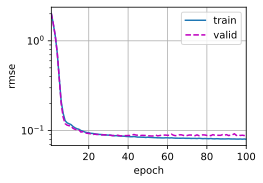

In [55]:
k, num_epochs, learning_rate, weight_decay, batch_size = 8, 100, 5e-2, 1e-2, 64
train_l, valid_l, pred_nets = k_fold(k, train_features, train_labels, num_epochs,
                           learning_rate, weight_decay, batch_size, net_type='mlp2')

print('%d-fold validation: avg train loss rmse %f, avg valid loss rmse %f' % (
          k, train_l, valid_l))

# 4.提交预测

In [56]:
# 预测数值，并保存至submission.csv
test_data['SalePrice'] = k_fold_predict(pred_nets, test_features)
submission = pd.concat([test_data[['Id']], test_data[['SalePrice']]], axis=1)
submission.to_csv('..\data\submission_5.csv', index=False)

# AutoML 实现

In [25]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
# train
train_data = TabularDataset('..\data\kaggle_house_pred_train.csv')
id, label = 'Id', 'SalePrice'
predictor = TabularPredictor(label=label).fit(
    train_data.drop(columns=[id]))

# predict
test_data = TabularDataset('..\data\kaggle_house_pred_test.csv')
predictions = predictor.predict(test_data.drop(columns=[id]))

# submit
submission = pd.DataFrame({id: test_data[id], label: predictions})
submission.to_csv('submission.csv', index=False)

Loaded data from: ..\data\kaggle_house_pred_train.csv | Columns = 81 / 81 | Rows = 1460 -> 1460


No path specified. Models will be saved in: "AutogluonModels\ag-20250818_131816"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       8.00 GB / 15.67 GB (51.0%)
Disk Space Avail:   172.44 GB / 465.75 GB (37.0%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize acc

[1000]	valid_set's rmse: 26908.7
[2000]	valid_set's rmse: 26617.6
[3000]	valid_set's rmse: 26569.8
[4000]	valid_set's rmse: 26566.1
[5000]	valid_set's rmse: 26569.2


	-26566.0786	 = Validation score   (-root_mean_squared_error)
	3.3s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBM ...
	Fitting with cpus=12, gpus=0, mem=0.0/8.1 GB


[1000]	valid_set's rmse: 29319.9
[2000]	valid_set's rmse: 28847.1
[3000]	valid_set's rmse: 28706.5
[4000]	valid_set's rmse: 28663.8
[5000]	valid_set's rmse: 28654.9
[6000]	valid_set's rmse: 28653.7
[7000]	valid_set's rmse: 28653.3
[8000]	valid_set's rmse: 28653.3
[9000]	valid_set's rmse: 28653.4


	-28653.3015	 = Validation score   (-root_mean_squared_error)
	7.94s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE ...
	Fitting with cpus=16, gpus=0
	-32547.6926	 = Validation score   (-root_mean_squared_error)
	0.66s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	Fitting with cpus=12, gpus=0
	-30800.849	 = Validation score   (-root_mean_squared_error)
	339.82s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	Fitting with cpus=16, gpus=0
	-31938.3616	 = Validation score   (-root_mean_squared_error)
	0.63s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	Fitting with cpus=12, gpus=0, mem=0.0/7.3 GB
	-31737.9798	 = Validation score   (-root_mean_squared_error)
	2.26s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	Fitting with cpus=12, gpus=0
	-29812.6009	 = Validation score   (-root_mean_squared_error)
	2.61s	 = Tra

[1000]	valid_set's rmse: 29504.4


	-29504.1986	 = Validation score   (-root_mean_squared_error)
	4.35s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'LightGBMXT': 0.8, 'XGBoost': 0.2}
	-26337.5824	 = Validation score   (-root_mean_squared_error)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 367.45s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 4631.1 rows/s (292 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("e:\Machine_learning\deeplearning\Dive_into_DL\AutogluonModels\ag-20250818_131816")
Loaded data from: ..\data\kaggle_house_pred_test.csv | Columns = 80 / 80 | Rows = 1459 -> 1459
